# STA 220 Assignment 1

Due __January 26, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__

Answer the following questions by querying [Lahman Baseball Database](http://seanlahman.com/). The 2019 version together with the description (`readme2019.txt`) are on Piazza. Answer the following questions. 

The purpose of this assignment is to practice accessing and analyzing data in a database. For full credit for (a) and (b), query the correct table with `pandas.read_sql` and a single SQL query. Unless otherwise specified, return in the same format of the test case. 

In [17]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import regex as re
import warnings
warnings.filterwarnings("ignore")

In [15]:
db = sql.connect("lahmansbaseballdb.sqlite")

__(a, i)__ Which pitcher has the second most [home runs allowed](https://en.wikipedia.org/wiki/Home_runs_allowed) in the American League? 

In [807]:
# most home runs allowed in the American League: 
result = pd.read_sql('''
                        SELECT 
                           people.nameFirst, 
                           people.nameLast, sum(pitching.hr) as hra 
                           from 
                              people 
                           join 
                              pitching on people.playerID = pitching.playerID 
                           where 
                              pitching.lgID = 'AL' 
                           group by 
                              people.playerID 
                           order by 
                              hra DESC LIMIT 1 
                           offset 1
                     ''', db).squeeze()
print(f"Pitcher who has the second most home runs allowed in the American League is {result['nameFirst'] + " " + result['nameLast']} with {str(result["hra"])} HRA")

Pitcher who has the second most home runs allowed in the American League is Tim Wakefield with 401 HRA


__(a, ii)__ Which pitcher has the worst home runs allowed per game ratio? 

In [816]:
result = pd.read_sql('''
                        SELECT 
                           people.nameFirst, 
                           people.nameLast, 
                           sum(pitching.hr)/sum(pitching.g)*1.0 as ratio 
                        from 
                           people 
                        inner join 
                           pitching on people.playerID = pitching.playerID 
                        group by 
                           people.playerID 
                        order by 
                           ratio DESC LIMIT 1
                     ''', db).squeeze()
print(f"Pitcher who has the worst home runs allowed per game ratio is {result['nameFirst'] + " " + result['nameLast']} with {str(result["ratio"])} ratio")

Pitcher who has the worst home runs allowed per game ratio is Larry Biittner with 3.0 ratio


__(b, i)__ Amongst all players in the American League that have passed, report their average lifespan in full years.  

In [16]:
result = pd.read_sql('''
                        SELECT 
                           ROUND(AVG(people.deathYear - people.birthYear)) AS AverageLifespan
                        FROM 
                           People 
                        WHERE 
                           playerID 
                        IN 
                           (SELECT DISTINCT playerID FROM Appearances WHERE lgID = 'AL') 
                        AND
                        death_date IS NOT NULL
                     ''', db).squeeze()
print(f"Amongst all players in the American League that have passed, their average lifespan in full years is {result}")

Amongst all players in the American League that have passed, their average lifespan in full years is 70.0


__(b, ii)__ Return the six schools with most hall-of-fame alumni.

In [677]:
result = pd.read_sql('''
                        SELECT 
                            s.name_full, 
                            COUNT(distinct h.playerID) AS HallOfFameAlumniCount
                        FROM 
                            HallOfFame h
                        JOIN 
                            CollegePlaying cp ON h.playerID = cp.playerID
                        JOIN 
                            Schools s ON cp.schoolID = s.schoolID
                        WHERE 
                            h.inducted = 'Y' 
                        GROUP BY 
                            s.name_full
                        ORDER BY 
                            HallOfFameAlumniCount DESC
                        LIMIT 6;

                     ''', db)
print(result)

                           name_full  HallOfFameAlumniCount
0  University of Southern California                      3
1            University of Minnesota                      2
2             University of Michigan                      2
3           University of Cincinnati                      2
4         St. Bonaventure University                      2
5         San Diego State University                      2


__(b, iii)__ What fraction of managers have not been professional players?  

In [671]:
result = pd.read_sql('''
                        SELECT 
                            COUNT(DISTINCT m.playerID)*1.0 / (SELECT COUNT(DISTINCT playerID) FROM Managers) 
                        AS 
                            NonProfessionalPlyrManagers
                        FROM 
                            Managers m
                        LEFT JOIN 
                            Appearances a ON m.playerID = a.playerID
                        WHERE 
                            a.playerID IS NULL;

                    ''', db).squeeze()
print(f'Fraction of managers have not been professional players is {result}')

Fraction of managers have not been professional players is 0.17507002801120447


__(c)__ Create a world map with a color gradient corresponding to the log-number of players per country in the data set. Use `pandas.read_html` to retrieve the ISO codes from [wikipedia](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes), and merge those records as good as you can. Match no more than ten countries to their ISOs manually. 

In [809]:
def manual_mapping(df):
    country_map = {'D.R.': 'Dominican Republic',
               'P.R.': 'Puerto Rico', 
               'V.I.': 'Virgin Islands',
               'USA': 'United States of America',
               'Netherlands': 'Netherlands, Kingdom of the',
               'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
               'CAN': 'Canada', 
               'Curacao': 'Curaçao',
               'Czech Republic': 'Czechia',
               'Russia': 'Russian Federation',
            }
    df['Country'] = df['Country'].apply(lambda country: country_map[country] if country in country_map else country)
    
    return df

In [810]:
def get_player_count(db):

    query = "SELECT birthCountry, count(*) FROM People group by birthCountry;"  
    players_df = pd.read_sql_query(query, db)
    players_df.columns = ['Country', 'PlayerCount']
    players_df = players_df.drop(4) ## to remove "At Sea"

    return players_df

In [811]:
players_df = get_player_count(db )
players_df_after_manual_mapping = manual_mapping(players_df)

In [812]:
url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"
iso_data = pd.read_html(url)

In [813]:
iso_df = pd.DataFrame(iso_data[0])
iso_df = iso_df[['ISO 3166[1]', 'ISO 3166-1[2]']]
iso_df['iso-a3'] = iso_df['ISO 3166-1[2]']['A-3 [5]']
iso_df = iso_df[['ISO 3166[1]', 'iso-a3']]
iso_df.columns = ['Country', 'iso_a3_code']
iso_df['Country'] = iso_df['Country'].apply(lambda country: 'South Korea' if country == 'Korea (the Republic of) [q]' else country)
iso_df['Country'] = iso_df['Country'].apply(lambda country: re.sub(r"\s*\(.*?\)\s*|\s*\[.*?\]\s*", "", str(country)))

In [814]:
merged_df = pd.merge(players_df, iso_df, on='Country', how='left')

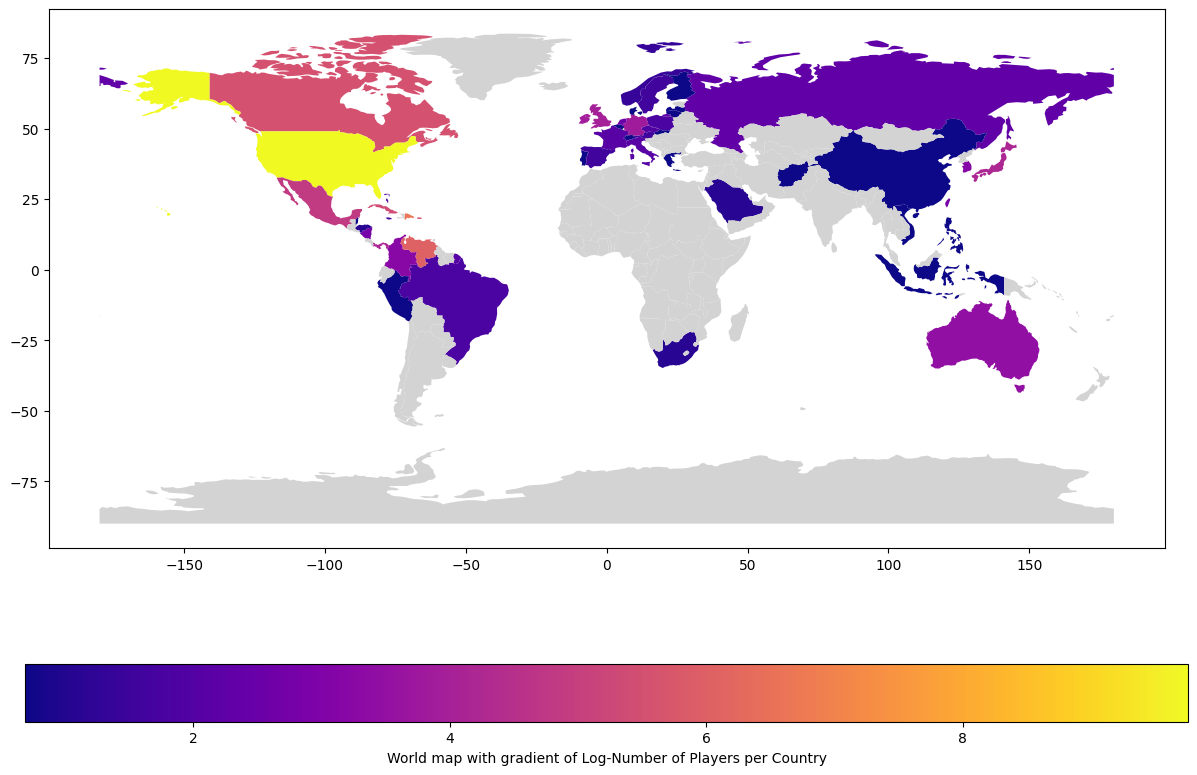

In [815]:
def create_world_plot_with_color_gradient(merged_df):
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_map = world_map.rename(columns={'iso_a3': 'iso_a3_code'})
    world_map = pd.merge(world_map, merged_df, on='iso_a3_code', how='left')
    world_map['logPlayerCount'] = np.log1p(world_map['PlayerCount'])

    _, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_map.plot(column='logPlayerCount', ax=ax, legend=True, cmap='plasma',
            legend_kwds={'label': "World map with gradient of Log-Number of Players per Country", 'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
    plt.show()
create_world_plot_with_color_gradient(merged_df)

__Exercise 2__

We will use the [lichess](https://lichess.org/api) API to retrieve some information about the current state of chess in the world. In order to answer below questions, make precise and economical requests. You may use:
```
import requests
import json
import pandas

from datetime import datetime
```

In [2]:
import requests
import json
from datetime import datetime
import time
import datetime

In [3]:
def get_api_key(keyfile):
    with open(keyfile) as fh:
        return fh.readline().strip('\n')
api_key = get_api_key('keys/lichess.txt')

__(a)__ What is the real name of the leader of the blitz leaderboard? 

In [4]:
def get_user_name_of_leader(nb, perfType):
    response = requests.get(f"https://lichess.org/api/player/top/{nb}/{perfType}", params={
        "api-key": api_key,
    })
    response = response.json()
    return response['users'][0]['username']

nb = 1
perfType = 'blitz'
username = get_user_name_of_leader(nb, perfType)

In [5]:
def get_full_name(username):
    response = requests.get(f"https://lichess.org/api/user/{username}", params={
        "api-key": api_key,
    })
    response = response.json()
    real_name = response['profile']['firstName']+" "+response['profile']['lastName']
    return real_name

real_name = get_full_name(username)
print(f"Real name of the leader of the blitz leaderboard is {real_name}")

Real name of the leader of the blitz leaderboard is Vladislav Artemiev


__(b, i)__ Get the username of the last player that played a rapid game against user `athena-pallada`. 

In [796]:
def get_username_of_last_player(username, perf):
   
    headers = {
        "Accept": "application/x-ndjson"
    }
    response_b1 = requests.get(f"https://lichess.org/api/games/user/{username}", headers=headers, params={
        "api-key": api_key,
        "perfType": perf,
        "max": 1
    })

    response_text = response_b1.text
    result_dict = json.loads(response_text)

    return result_dict

username = 'athena-pallada'
perfType = 'rapid'
result_dict = get_username_of_last_player(username, perfType)

In [797]:
opponents_username = result_dict['players']['white']['user']['name'] \
                    if (result_dict['players']['black']['user']['name'] == 'athena-pallada') \
                    else result_dict['players']['black']['user']['name']

print("Username of the last player that played a rapid game against user athena-pallada is ",opponents_username)

Username of the last player that played a rapid game against user athena-pallada is  Bacio129


__(b, ii)__ In all games against this user, how many times did `athena-pallada` win? _(Provide code that answers the question in case more than just a single game is returned)_

In [798]:
def get_all_games(username):

    headers = {
        "Accept": "application/x-ndjson"
    }
    response_b2 = requests.get(f"https://lichess.org/api/games/user/{username}", headers=headers, params={
        "api-key": api_key
    })

    response_text = response_b2.text
    response_text = response_text.strip().split('\n')

    return response_text

opponents_username = 'Bacio129'
username = 'athena-pallada'

response_text = get_all_games(opponents_username)

In [801]:
numberOfWins = 0
for game in response_text:
    game = json.loads(game)
    if('user' in game['players']['black'] and game['players']['black']['user']['name'] == username and 'winner' in game and game['winner'] == 'black'):
            numberOfWins+=1
    elif('user' in game['players']['white'] and game['players']['white']['user']['name'] == username and 'winner' in game and game['winner'] == 'white'):
            numberOfWins+=1
print(f"{username} won {numberOfWins} times against {opponents_username} in all the games played")

athena-pallada won 2 times against Bacio129 in all the games played


__(c)__ Consider the top ten players in the bullet leaderboard. 

In [7]:
def get_top_10_players(nb, perfType):
    
    response = requests.get(f"https://lichess.org/api/player/top/{nb}/{perfType}", params={
        "api-key": api_key,
    })
    response_c1 = response.json()
    return response_c1

nb = 10
perfType = 'bullet'

response_c1 = get_top_10_players(nb, perfType)

In [8]:
users = response_c1['users']
usernames = []
for user in users:
    usernames.append(user['username'])
print("Top 10 players in teh bullet leaderboard are ")
usernames

Top 10 players in teh bullet leaderboard are 


['Ediz_Gurel',
 'RedWarrior25',
 'Mishka_The_Great',
 'V_M',
 'klari64',
 'Yulkaaa',
 'Hooligan64',
 'Watneg',
 'aaryan_varshney',
 'LastGladiator2']

__(i)__ Which player has the most bullet games overall? 

In [9]:
max_games_played = -1
user_with_max_bullet_games = ""
users = {}
for username in usernames:
    response = requests.get(f"https://lichess.org/api/user/{username}", params={
        "api-key": api_key,
    })
    time.sleep(5)   ## To avoid making many requests in short span of time
    response = response.json()
    users[username] = response
    games_played = response['perfs']['bullet']['games']
    if(games_played > max_games_played):
        max_games_played = games_played
        user_with_max_bullet_games = username

print(f"{user_with_max_bullet_games} palyed {max_games_played} number of bullet games")


Mishka_The_Great palyed 61298 number of bullet games


__(ii)__ Which player has played the most bullet games relative to account age in days? 

In [10]:
ratio = -1
user_with_most_bullet_games_relative_to_account_age = ""
days = 0
bullet_games = 0
for username in usernames:
    response_c2 = users[username]
    bullet_games_played = response_c2['perfs']['bullet']['games']
    created_at = response_c2['createdAt']
    curr_days = (datetime.datetime.now() - datetime.datetime.fromtimestamp(created_at/1000)).days
    
    curr_ratio = bullet_games_played / (1.0*curr_days)
    if(curr_ratio > ratio):
        ratio = curr_ratio
        user_with_most_bullet_games_relative_to_account_age = username
        days = curr_days
        bullet_games = bullet_games_played


print(f"{user_with_most_bullet_games_relative_to_account_age} palyed most bullet games {bullet_games} relative to account age {days} days")

Mishka_The_Great palyed most bullet games 61298 relative to account age 2184 days


__(iii)__ Which player has the worst win-to-loss ratio over all formats?

In [11]:
worst_ratio = float("inf")
user_with_worst_win_to_loss_ratio = ""
for username in usernames:
    response_c3 = users[username]
    win = response_c3['count']['win']
    loss = response_c3['count']['loss']
    ratio = win/loss
    if(ratio < worst_ratio):
        worst_ratio = ratio
        user_with_worst_win_to_loss_ratio = username

print(f"User with worst win-to-loss ratio {worst_ratio} over all formats is {user_with_worst_win_to_loss_ratio}")

User with worst win-to-loss ratio 1.4608555286521387 over all formats is klari64


__(d)__ Get all games from user `manwithavan`. Group them by opening and print the ten most popular. 

In [319]:
username = 'manwithavan'
headers = {
    "Accept": "application/x-ndjson"
}
response_d = requests.get(f"https://lichess.org/api/games/user/{username}", headers=headers, params={
    "api-key": api_key,
    "opening": True
})

In [320]:
openings = {}
response_text = response_d.text
json_objects = response_text.strip().split('\n')


for json_object in json_objects:
    games = json.loads(json_object)
    if('opening' not in games):
        continue
    if games['opening']['name'] not in openings:
        openings[games['opening']['name']] = 1
    else:
        openings[games['opening']['name']] += 1

openings_popularity = [(freq, opening) for (opening, freq) in openings.items()]
openings_popularity = sorted(openings_popularity, reverse=True)

ten_most_popular_openings = []
count = 0
print(f"Ten most popular openings by {username}")
for freq, opening in openings_popularity:
    if(count == 10):
        break
    ten_most_popular_openings.append(opening)
    print(opening, freq)
    count += 1

Ten most popular openings by manwithavan
Van't Kruijs Opening 7
Nimzo-Larsen Attack: Modern Variation 7
Pirc Defense 6
Mieses Opening 6
Zukertort Opening: Queenside Fianchetto Variation 5
Zukertort Opening: Kingside Fianchetto 5
Queen's Pawn Game 5
Nimzo-Larsen Attack 5
Modern Defense 5
Caro-Kann Defense: Tartakower Variation 5
